# YAP 471 Computational Finance Project - Spring 2023-2024
Author: Ömer Faruk Merey

Student Number: 201101054

Topic: Optimal Portfolio based on Future Price Prediction.

Note: This note will be compared with Kerem Ihsan Ulasans work to report the comparison on portfolio creation.

Github Repo: https://github.com/OmerFarukMerey/Risk-Analysis-and-Portfolio-Creation-with-Genetic-Algorithms-using-statiscal-analysis

### Table of Contents
* [Tool Requirements](#tool)
* [CNN-LSTM](#cnn_lstm)
    * [Data Preparation](#data_prep_cnn_lstm)
    * [Model](#model_cnn_lstm)
    * [Evaluation](#eval_cnn_lstm)
* [RNN](#rnn)
    * [Data Preparation](#data_prep_rnn)
    * [Model](#model_rnn)
    * [Evaluation](#eval_rnn)
* [XGBoost](#xgboost)
    * [Data Preparation](#data_prep_xgboost)
    * [Model](#model_xgboost)
    * [Evaluation](#eval_xgboost)
* [Save Datasets](#save_datasets)

In [220]:
# Put on the name of the Stock
STOCK_NAME = "GOOG"
DF_POSTFIX = "_Predictions.csv"

# Tool Requirements<a class="anchor" id="tool"></a>
Contains imports and helper functions for the upcoming sections

In [195]:
# Download neccessary libs
!pip install ta
!pip install yfinance
!pip install tensorflow
!pip install xgboost

In [221]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from ta.volatility import BollingerBands
from ta.trend import MACD
from ta.momentum import RSIIndicator
from keras.models import Sequential
from keras.layers import Conv1D,MaxPool1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from ta.trend import IchimokuIndicator
from sklearn.linear_model import LinearRegression
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed,MaxPool2D
from keras.layers import Dense,GlobalAveragePooling2D
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [222]:
def download_stock(stock_name):
    """
    Downloads the stock dataframe and returns it.
    """
    print(f"Downloading the data for {stock_name}")
    df = yf.download(
        [stock_name],
        group_by="ticker",
        start="2010-01-01",
        end="2024-01-01",
        progress=False,
    )
    print(f"Download complete for {stock_name}")
    #df.round(4)
    df = df.reset_index()
    return df

def create_corr_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
    plt.title('Stock Correlation Matrix Heatmap')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
    
def create_moving_average(df, moving_average_days=[20, 50, 100, 200]):
    for moving_average in moving_average_days:
        for company in df:
            column_name = f'MA{moving_average}'
            df[column_name] = df["Close"].rolling(moving_average).mean()
    return df.iloc[max(moving_average_days):]

def create_bollinger_bands(df):
    indicator_bb = BollingerBands(close=df["Close"])
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    df['bb_bbh'] = indicator_bb.bollinger_hband()
    df['bb_bbl'] = indicator_bb.bollinger_lband()
    return df

def create_macd(df):
    macd = MACD(close=df["Close"])
    df['macd'] = macd.macd()
    return df

def create_rsi(df):
    rsi = RSIIndicator(close=df["Close"])
    df['rsi'] = rsi.rsi()
    return df

def create_ichi(df):
    ichi = IchimokuIndicator(high=df["High"],low=df["Low"])
    df['ichi_a'] = ichi.ichimoku_a()
    df['ichi_b'] = ichi.ichimoku_b()
    df['ichi_base'] = ichi.ichimoku_base_line()
    df['ichi_conv'] = ichi.ichimoku_conversion_line()
    return df

def get_2020_first_index(df):
    x = df[df["Date"] > '2020-01-01'].index[0]
    return x

def get_first_index(df):
    x = df.index[0]
    return x

def create_pred_real_df(test_label, predicted):
    volatility = calculate_volatility(predicted)
    
    df = pd.DataFrame({
        "Real": test_label.ravel(),
        "Predicted": predicted.ravel(),
        "Volatility": volatility,
    }, index = stock.index[-len(test_label):])
    df.reset_index(inplace=True)
    df.drop("index", inplace=True, axis=1)
    return df

def val_train_loss_plot(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title(f"{STOCK_NAME} Train - Val Loss")
    plt.legend()
    
def val_train_mse_plot(history):
    plt.plot(history.history['mse'], label='train mse')
    plt.plot(history.history['val_mse'], label='val mse')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title(f"{STOCK_NAME} Train - Val Mean Squared Error")
    plt.legend()
    
def val_train_mae(history):
    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_mae'], label='val mae')
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.title(f"{STOCK_NAME} Train - Val Mean Absolute Error")
    plt.legend()
    
def calculate_volatility(prices):
    log_scale = np.log(prices[1:] / prices[:-1])
    volatility = [0] # first day
    for i in range(1, len(log_scale)+1):
        # i gününe kadar olan log getirilerin standart sapması hesaplanır ve yıllıklaştırılır
        vol = np.std(log_scale[:i]) * np.sqrt((len(log_scale)))
        volatility.append(vol)
    
    return volatility

def save_xgboost_df():
    xgboost_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)
    
def save_rnn_df():
    rnn_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)
    
def save_cnn_lstm_df():
    cnn_lstm_df.to_csv(STOCK_NAME + DF_POSTFIX, index=False)

In [223]:
# get stock
stock = download_stock(STOCK_NAME)

stock = create_moving_average(stock)
stock = create_bollinger_bands(stock)
stock = create_macd(stock)
stock = create_rsi(stock)
stock = create_ichi(stock)

stock = stock.fillna(0)
stock.head()

Download complete for GOOG


,Date,Open,High,Low,Close,Adj Close,Volume,MA20,MA50,MA100,MA200,bb_bbm,bb_bbh,bb_bbl,macd,rsi,ichi_a,ichi_b,ichi_base,ichi_conv
200,2010-10-19,15.164410,15.313103,15.015219,15.139005,15.139005,184203863,13.507109,12.507245,12.250278,12.923740,0.0,0.0,0.0,0.0,0.0,0.0,15.164161,0.0,0.0
201,2010-10-20,15.146726,15.376864,15.130786,15.142741,15.142741,141532518,13.621655,12.559185,12.280751,12.921746,0.0,0.0,0.0,0.0,0.0,0.0,15.196042,0.0,0.0
202,2010-10-21,15.230662,15.342493,15.093426,15.242617,15.242617,117257870,13.744333,12.619086,12.313035,12.922211,0.0,0.0,0.0,0.0,0.0,0.0,15.196042,0.0,0.0
203,2010-10-22,15.240873,15.313103,15.194298,15.256067,15.256067,90582257,13.850485,12.679120,12.342714,12.924506,0.0,0.0,0.0,0.0,0.0,0.0,15.196042,0.0,0.0
204,2010-10-25,15.332281,15.560177,15.316839,15.354946,15.354946,126809538,13.957696,12.743952,12.370335,12.926309,0.0,0.0,0.0,0.0,0.0,0.0,15.287698,0.0,0.0


In [224]:
f_index = get_first_index(stock)
s_index = get_2020_first_index(stock)
train_test_split_index = s_index-f_index

# CNN-LSTM <a class="anchor" id="cnn_lstm"></a>

## Data Preparation <a class="anchor" id="data_prep_cnn_lstm"></a>

In [180]:
stock.iloc[:, 5]

200       7.933500
201       7.933500
202       8.248500
203       8.456500
204       8.450000
           ...    
3584    180.690002
3585    182.410004
3586    180.000000
3587    185.070007
3588    186.309998
Name: Adj Close, Length: 3389, dtype: float64

In [181]:
X = []
Y = []
window_size=100
for i in range(1 , len(stock) - window_size -1 , 1):
    first = stock.iloc[i,5]
    temp = []
    temp2 = []
    for j in range(window_size):
        temp.append((stock.iloc[i + j, 5] - first) / first)
    temp2.append((stock.iloc[i + window_size, 5] - first) / first)
    X.append(np.array(temp).reshape(100, 1))
    Y.append(np.array(temp2).reshape(1, 1))

x_train = X[:train_test_split_index]
x_test = X[train_test_split_index:]
y_train = Y[:train_test_split_index]
y_test = Y[train_test_split_index:]

train_X = np.array(x_train)
test_X = np.array(x_test)
train_Y = np.array(y_train)
test_Y = np.array(y_test)

train_X = train_X.reshape(train_X.shape[0],1,100,1)
test_X = test_X.reshape(test_X.shape[0],1,100,1)

print(len(train_X))
print(len(test_X))

2316
971


## Model <a class="anchor" id="model_cnn_lstm"></a>

In [183]:
cnn_lstm_model = tf.keras.Sequential()

# Creating the Neural Network model here...
# CNN layers
cnn_lstm_model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu', input_shape=(None, 100, 1))))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm_model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm_model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
cnn_lstm_model.add(TimeDistributed(MaxPooling1D(2)))
cnn_lstm_model.add(TimeDistributed(Flatten()))
# model.add(Dense(5, kernel_regularizer=L2(0.01)))

# LSTM layers
cnn_lstm_model.add(Bidirectional(LSTM(100, return_sequences=True)))
cnn_lstm_model.add(Dropout(0.5))
cnn_lstm_model.add(Bidirectional(LSTM(100, return_sequences=False)))
cnn_lstm_model.add(Dropout(0.5))

#Final layers
cnn_lstm_model.add(Dense(1, activation='linear'))
cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

history = cnn_lstm_model.fit(train_X, train_Y, validation_data=(test_X,test_Y), epochs=100, batch_size=40, verbose=1, shuffle =False)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0215 - mae: 0.1207 - mse: 0.0215 - val_loss: 0.0177 - val_mae: 0.1058 - val_mse: 0.0178
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0106 - mae: 0.0830 - mse: 0.0106 - val_loss: 0.0130 - val_mae: 0.0905 - val_mse: 0.0132
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0079 - mae: 0.0713 - mse: 0.0079 - val_loss: 0.0096 - val_mae: 0.0767 - val_mse: 0.0096
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0074 - mae: 0.0689 - mse: 0.0074 - val_loss: 0.0108 - val_mae: 0.0812 - val_mse: 0.0107
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0070 - mae: 0.0666 - mse: 0.0069 - val_loss: 0.0092 - val_mae: 0.0738 - val_mse: 0.0091
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0067 - mae: 0.0649 - mse: 0.0067 - val_loss: 0.0116 - val_mae: 0.0838 - val_mse: 0.0114
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - mae: 0.0646 - mse: 0.0066 - va

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - mae: 0.0479 - mse: 0.0037 - val_loss: 0.0064 - val_mae: 0.0600 - val_mse: 0.0063
Epoch 46/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0035 - mae: 0.0460 - mse: 0.0035 - val_loss: 0.0071 - val_mae: 0.0623 - val_mse: 0.0069
Epoch 47/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0451 - mse: 0.0034 - val_loss: 0.0061 - val_mae: 0.0587 - val_mse: 0.0060
Epoch 48/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - mae: 0.0455 - mse: 0.0035 - val_loss: 0.0058 - val_mae: 0.0582 - val_mse: 0.0058
Epoch 49/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0453 - mse: 0.0034 - val_loss: 0.0055 - val_mae: 0.0553 - val_mse: 0.0055
Epoch 50/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - mae: 0.0447 - mse: 0.0034 - val_loss: 0.0064 - val_mae: 0.0598 - val_mse: 0.0063
Epoch 51/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - mae: 0.0443 - mse: 0.0033 - val_loss:

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - mae: 0.0343 - mse: 0.0019 - val_loss: 0.0110 - val_mae: 0.0781 - val_mse: 0.0107
Epoch 90/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - mae: 0.0345 - mse: 0.0019 - val_loss: 0.0119 - val_mae: 0.0808 - val_mse: 0.0117
Epoch 91/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - mae: 0.0331 - mse: 0.0018 - val_loss: 0.0111 - val_mae: 0.0795 - val_mse: 0.0109
Epoch 92/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - mae: 0.0344 - mse: 0.0019 - val_loss: 0.0114 - val_mae: 0.0801 - val_mse: 0.0113
Epoch 93/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - mae: 0.0344 - mse: 0.0019 - val_loss: 0.0107 - val_mae: 0.0767 - val_mse: 0.0105
Epoch 94/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0022 - mae: 0.0366 - mse: 0.0022 - val_loss: 0.0105 - val_mae: 0.0776 - val_mse: 0.0103
Epoch 95/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - mae: 0.0421 - mse: 0.0031 - val_loss:

## Evaluation <a class="anchor" id="eval_cnn_lstm"></a>

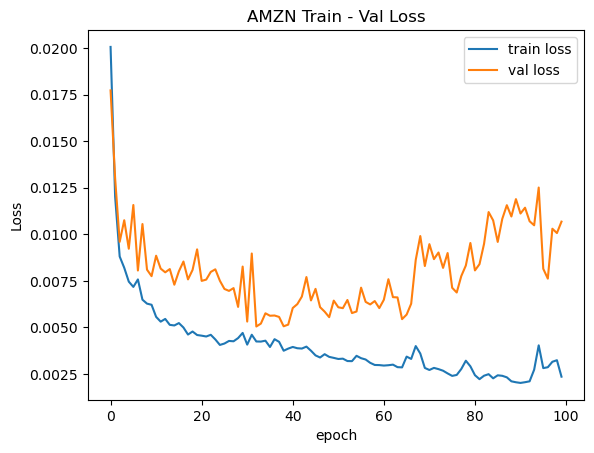

In [184]:
val_train_loss_plot(history)

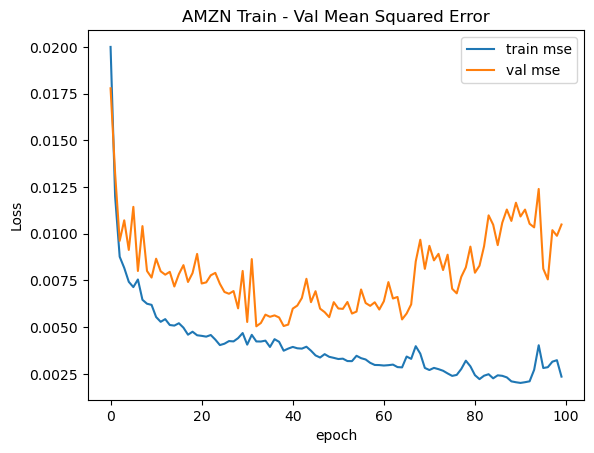

In [185]:
val_train_mse_plot(history)

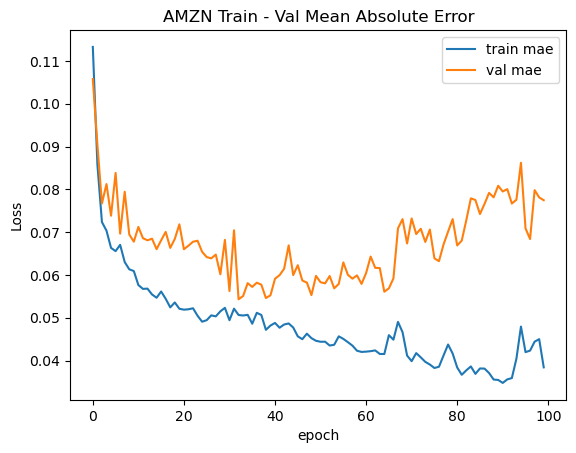

In [186]:
val_train_mae(history)

In [187]:
# After the model has been constructed, we'll summarise it
from tensorflow.keras.utils import plot_model
print(cnn_lstm_model.summary())
plot_model(cnn_lstm_model, to_file='CNN_LSTM.png', show_shapes=True, show_layer_names=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_28                  │ (None, 1, 98, 64)           │             256 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 1, 49, 64)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_30                  │ (None, 1, 47, 128)          │          24,704 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_31                  │ (None, 1, 23, 128)          │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_32                  │ (None, 1, 21, 64)           │          24,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_33                  │ (None, 1, 10, 64)           │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_34                  │ (None, 1, 640)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 1, 200)              │         592,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 200)                 │         240,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,650,205 (10.11 MB)

 Trainable params: 883,401 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,766,804 (6.74 MB)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [188]:
cnn_lstm_model.evaluate(test_X, test_Y)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - mae: 0.0837 - mse: 0.0130


[0.010630911216139793, 0.07746235281229019, 0.010495569556951523]

In [189]:
yhat_probs = cnn_lstm_model.predict(test_X, verbose=0)
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(test_Y.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(test_Y.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(test_Y.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.811188
R2 Score: 0.811188
Max Error: 0.365385


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


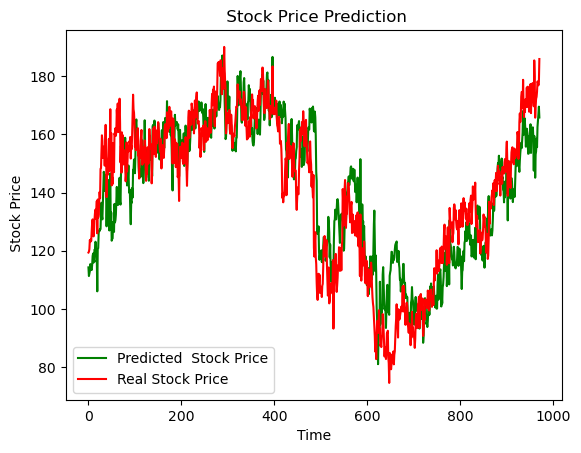

In [190]:
predicted  = cnn_lstm_model.predict(test_X)
test_label = test_Y.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(train_X)
for j in range(len_t , len_t + len(test_X)):
    temp = stock.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [191]:
avg_mse = sum(history.history["mse"]) / len(history.history["mse"])
min_mse = min(history.history["mse"])
max_mse = max(history.history["mse"])
avg_mse, min_mse, max_mse 

(0.004035014144610613, 0.0020129180047661066, 0.020004739984869957)

In [192]:
cnn_lstm_df = create_pred_real_df(test_label, predicted)
cnn_lstm_df

,Real,Predicted,Volatility
0,119.362191,114.261436,0.000000
1,119.655441,111.285789,0.000000
2,120.515779,112.177689,0.535225
3,123.625065,112.952316,0.496730
4,122.967646,115.384201,0.547750
...,...,...,...
966,178.188854,162.565430,1.199708
967,177.728920,164.633942,1.199151
968,176.849885,166.921341,1.198607
969,177.998309,169.509003,1.198082


# RNN <a class="anchor" id="rnn"></a>

## Data Preparation <a class="anchor" id="data_prep_rnn"></a>

In [176]:
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(stock.drop("Date", axis=1))
window_size = 100

X = []
y = []
for i in range(window_size, len(stock)):
    X.append(training_set_scaled[i-window_size:i, 0])
    y.append(training_set_scaled[i, 0])
    
X_train = X[:train_test_split_index]
X_test = X[train_test_split_index:]
y_train = y[:train_test_split_index]
y_test = y[train_test_split_index:]

X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(len(X_train))
print(len(X_test))

2316
906


## Model <a class="anchor" id="model_rnn"></a>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

rnn_model = Sequential()

rnn_model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50, return_sequences = True))
rnn_model.add(Dropout(0.2))
rnn_model.add(LSTM(units = 50))
rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units = 1))

rnn_model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse', 'mae'])
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 25, batch_size = 32, shuffle=False)

## Evaluation <a class="anchor" id="eval_rnn"></a>

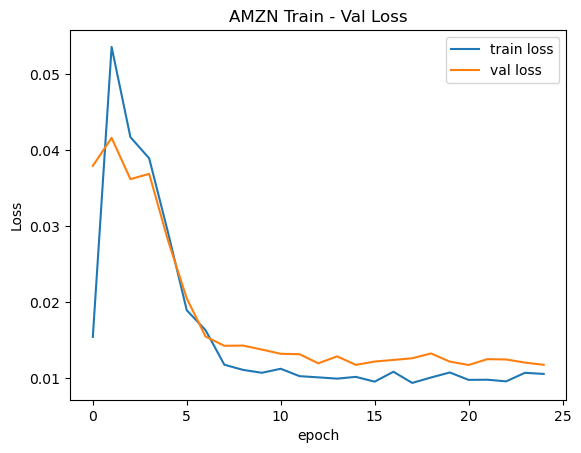

In [167]:
val_train_loss_plot(history)

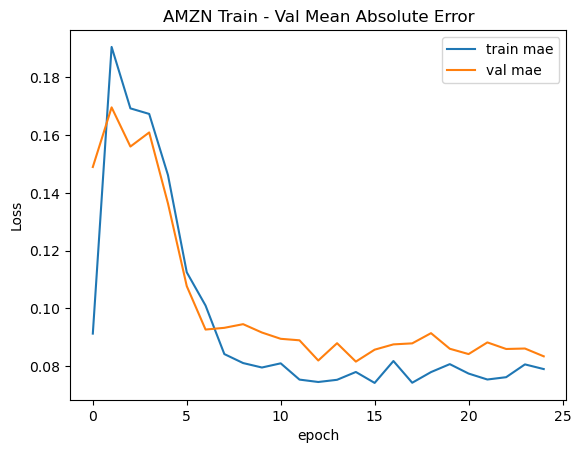

In [168]:
val_train_mae(history)

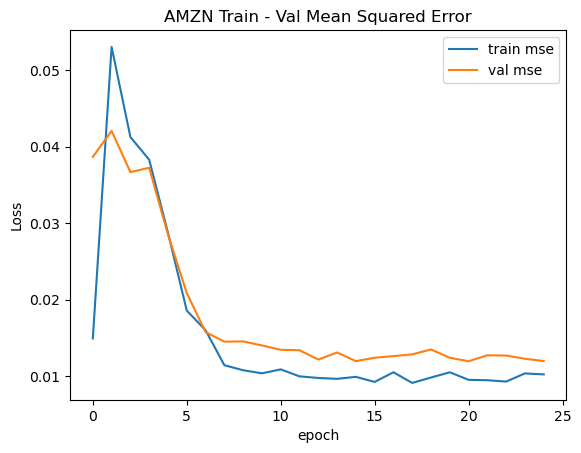

In [169]:
val_train_mse_plot(history)

In [170]:
print(rnn_model.summary())
plot_model(rnn_model, to_file='RNN.png', show_shapes=True, show_layer_names=True)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 15, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 15, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 15, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 15, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,155 (832.64 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,104 (555.10 KB)

None
You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [171]:
rnn_model.evaluate(X_test, y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - mae: 0.1244 - mse: 0.0208


[0.017421219497919083, 0.11109963804483414, 0.017736461013555527]

In [172]:
yhat_probs = rnn_model.predict(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]

var = explained_variance_score(y_test.reshape(-1,1), yhat_probs)
print('Variance: %f' % var)

r2 = r2_score(y_test.reshape(-1,1), yhat_probs)
print('R2 Score: %f' % var)

var2 = max_error(y_test.reshape(-1,1), yhat_probs)
print('Max Error: %f' % var2)

Variance: 0.761647
R2 Score: 0.761647
Max Error: 0.339793


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


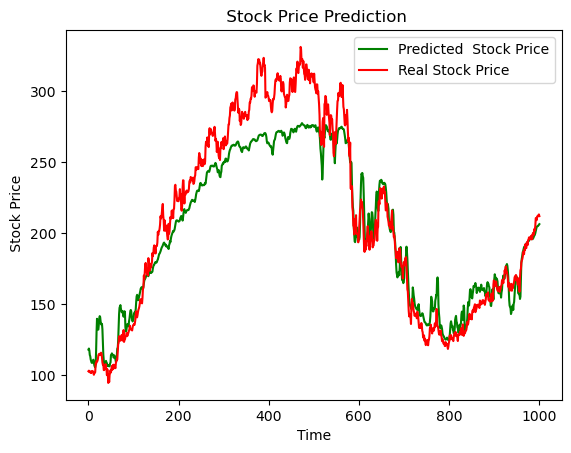

In [173]:
predicted  = rnn_model.predict(X_test)
test_label = y_test.reshape(-1,1)
predicted = np.array(predicted[:,0]).reshape(-1,1)
len_t = len(X_train)
for j in range(len_t , len_t + len(X_test)):
    temp = stock.iloc[j,3]
    test_label[j - len_t] = test_label[j - len_t] * temp + temp
    predicted[j - len_t] = predicted[j - len_t] * temp + temp
plt.plot(predicted, color = 'green', label = 'Predicted  Stock Price')
plt.plot(test_label, color = 'red', label = 'Real Stock Price')
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend()
plt.show()

In [85]:
avg_mse = sum(history.history["mse"]) / len(history.history["mse"])
min_mse = min(history.history["mse"])
max_mse = max(history.history["mse"])
avg_mse, min_mse, max_mse 

(0.015659318044781684, 0.009108979254961014, 0.05302729085087776)

In [86]:
rnn_df = create_pred_real_df(test_label, predicted)
rnn_df

,Real,Predicted,Volatility
0,18.180378,22.032681,0.000000
1,18.207608,22.671768,0.000000
2,18.267331,23.500938,0.115896
3,18.491248,23.400011,0.553436
4,18.605185,23.019072,0.692486
...,...,...,...
997,360.834182,361.061279,0.501910
998,363.700880,359.344849,0.501716
999,367.126961,361.568298,0.501476
1000,362.895809,362.942780,0.501226


# XGBoost <a class="anchor" id="xgboost"></a>

## Data Preparation <a class="anchor" id="data_prep_xgboost"></a>

In [225]:
stock["Pct_change"] = stock["Adj Close"].pct_change()

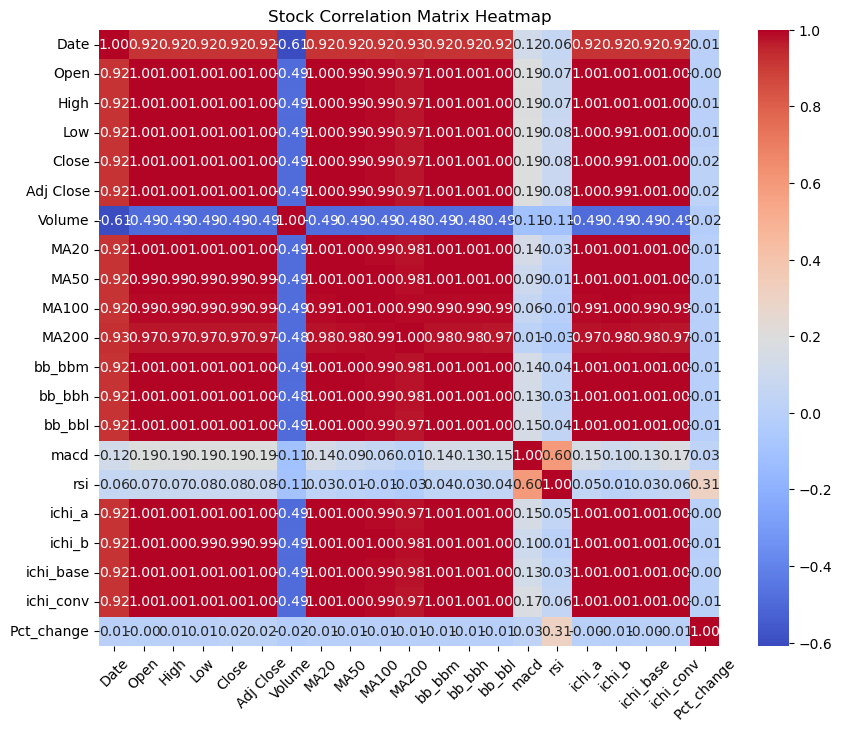

In [226]:
create_corr_matrix(stock)

In [227]:
# Dataframe with Adj close, ts_polarity, twitter_volume of APPL
stock = stock[["Adj Close", "rsi", "Volume", "MA200", "Pct_change"]]
stock.dropna(inplace = True)
stock

,Adj Close,rsi,Volume,MA200,Pct_change
201,15.142741,0.000000,141532518,12.921746,0.000247
202,15.242617,0.000000,117257870,12.922211,0.006596
203,15.256067,0.000000,90582257,12.924506,0.000882
204,15.354946,0.000000,126809538,12.926309,0.006481
205,15.407250,0.000000,100892759,12.928487,0.003406
...,...,...,...,...,...
3517,142.720001,64.953258,18494700,124.814525,0.006488
3518,142.820007,65.115855,11170100,125.073575,0.000701
3519,141.440002,60.916000,17288400,125.322475,-0.009663
3520,141.279999,60.429335,12192500,125.557625,-0.001131


In [228]:
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, feature_col_number4, feature_col_number5, target_col_number):
    # Create empty lists "X_adj_close", "rsi", "X_volume" and y
    X_adj_close = []
    X_rsi = []
    X_ma200 = []
    X_volume = []
    X_pct_change = []
    y = []
    for i in range(len(df) - window):
        adj_close = df.iloc[i:(i + window), feature_col_number1]
        rsi = df.iloc[i:(i + window), feature_col_number2]
        volume = df.iloc[i:(i + window), feature_col_number3]
        ma_200 = df.iloc[i:(i + window), feature_col_number4]
        pct_change = df.iloc[i:(i + window), feature_col_number5]
        target = df.iloc[(i + window), target_col_number]

        # Append values in the lists
        X_adj_close.append(adj_close)
        X_rsi.append(rsi)
        X_volume.append(volume)
        X_ma200.append(ma_200)
        X_pct_change.append(pct_change)
        y.append(target)

    return np.hstack((X_adj_close, X_rsi, X_volume, X_ma200, X_pct_change)), np.array(y).reshape(-1, 1)

In [229]:
window_size = 3
X, y = window_data(stock, window_size, 0, 1, 2, 3, 4, 0)
X, y

(array([[ 1.51427412e+01,  1.52426167e+01,  1.52560673e+01, ...,
          2.46812525e-04,  6.59559909e-03,  8.82435271e-04],
        [ 1.52426167e+01,  1.52560673e+01,  1.53549461e+01, ...,
          6.59559909e-03,  8.82435271e-04,  6.48128110e-03],
        [ 1.52560673e+01,  1.53549461e+01,  1.54072504e+01, ...,
          8.82435271e-04,  6.48128110e-03,  3.40634656e-03],
        ...,
        [ 1.41800003e+02,  1.42720001e+02,  1.42820007e+02, ...,
          1.53229223e-02,  6.48799823e-03,  7.00715405e-04],
        [ 1.42720001e+02,  1.42820007e+02,  1.41440002e+02, ...,
          6.48799823e-03,  7.00715405e-04, -9.66254595e-03],
        [ 1.42820007e+02,  1.41440002e+02,  1.41279999e+02, ...,
          7.00715405e-04, -9.66254595e-03, -1.13124759e-03]]),
 array([[ 15.35494614],
        [ 15.4072504 ],
        [ 15.35419941],
        ...,
        [141.44000244],
        [141.27999878],
        [140.92999268]]))

In [230]:
X_train = X[: train_test_split_index]
X_test = X[train_test_split_index:]
y_train = y[: train_test_split_index]
y_test = y[train_test_split_index:]

In [231]:
from sklearn.preprocessing import MinMaxScaler

# Use the MinMaxScaler to scale data between 0 and 1.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

print(len(X_train))
print(len(X_test))

2316
1002


## Model <a class="anchor" id="model_xgboost"></a>

In [232]:
parameters = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12],
    'gamma': [0.001, 0.01],
    'random_state': [42]
}

model = XGBRegressor(objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters, cv=5, verbose=False)

In [233]:
clf.fit(X_train, y_train.ravel())

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

Best params: {'gamma': 0.001, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42}
Best validation score = -0.6571082591529631


In [234]:
model_xgboost = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model_xgboost.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.001, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## Evaluation <a class="anchor" id="eval_xgboost"></a>

In [235]:
predicted = model_xgboost.predict(X_test)
predicted

array([0.14500195, 0.15506124, 0.16475545, ..., 0.8810581 , 0.88378197,
       0.8805367 ], dtype=float32)

In [236]:
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

Root Mean Squared Error: 0.056898109856763815
R-squared : 0.9517346981426469


In [237]:
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [238]:
predicted

array([0.14500195, 0.15506124, 0.16475545, ..., 0.8810581 , 0.88378197,
       0.8805367 ], dtype=float32)

In [239]:
y_test_scaler.inverse_transform(predicted.reshape(-1,1))

array([[ 67.0235 ],
       [ 68.00809],
       [ 68.95694],
       ...,
       [139.0672 ],
       [139.33382],
       [139.01617]], dtype=float32)

In [240]:
xgboost_df = create_pred_real_df(real_prices, predicted_prices)
xgboost_df

,Real,Predicted,Volatility
0,70.216003,67.023499,0.000000
1,70.991501,68.008087,0.000000
2,71.486504,68.956940,0.011512
3,71.961502,69.137611,0.173305
4,71.543999,69.333626,0.182049
...,...,...,...
997,142.720001,139.224197,0.572665
998,142.820007,139.434448,0.572379
999,141.440002,139.067200,0.572102
1000,141.279999,139.333817,0.571817


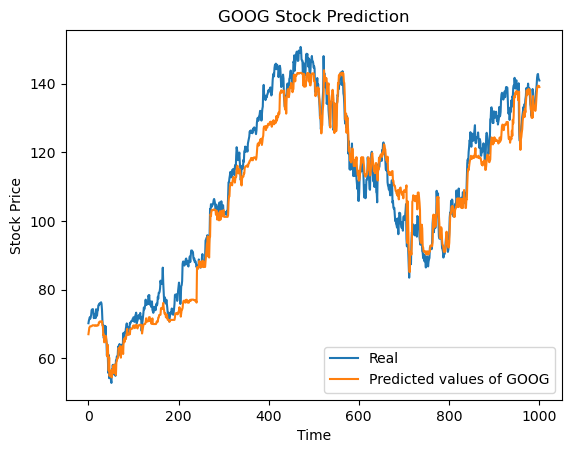

In [241]:
plt.plot(real_prices, label = 'Real')
plt.plot(predicted_prices, label = f'Predicted values of {STOCK_NAME}')
plt.title(f'{STOCK_NAME} Stock Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Save Datasets <a class="anchor" id="save_datasets"></a>

In [242]:
if STOCK_NAME == "GOOG":
    save_xgboost_df()